El objetivo es enontrar la relación existente entre las distintas variables con relación a la hospitalización

In [29]:
#Importo al librerías que usaré en principio. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Traigo mi excel
df = pd.read_excel(r'C:\Users\Patricia\Downloads\M6-20230624T155714Z-001\M6\Proyecto Integrador\Propuesta 1\BBDD_Hospitalización.xlsx')




C:\Users\Patricia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [31]:
# Normalizo los datos para capitalizar solo la primera letra en mayúsculas.

df = df.applymap(lambda x: x.title() if isinstance(x, str) else x)
df.head(3)

,EDAD,DIABETES,HOSPITALIZACIÓN ULTIMO MES,PSA,BIOPSIAS PREVIAS,VOLUMEN PROSTATICO,ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS,NUMERO DE MUESTRAS TOMADAS,CUP,ENF. CRONICA PULMONAR OBSTRUCTIVA,BIOPSIA,NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA,FIEBRE,ITU,TIPO DE CULTIVO,AGENTE AISLADO,PATRON DE RESISTENCIA,HOSPITALIZACION,DIAS HOSPITALIZACION MQ,DIAS HOSPITALIZACIÓN UPC
0,53.0,No,No,4.0,No,Si,Fluoroquinolona_Aminoglicosido,12.0,No,No,Neg,1,Si,No,No,No,No,Si,2.0,0.0
1,56.0,No,No,7.7,No,Si,Fluoroquinolona_Aminoglicosido,12.0,No,No,Neg,1,Si,No,No,No,No,Si,5.0,0.0
2,57.0,No,No,29.0,Si,Si,Fluoroquinolona_Aminoglicosido,24.0,No,No,Neg,1,Si,No,Hemocultivo,E.Coli,"Ampi R, Cipro R, Genta R, Sulfa M R",Si,4.0,3.0


In [32]:
#Verifico cuantos valores nulos tengo por columnas

df.isnull().sum()

EDAD                                                                          2
DIABETES                                                                      2
HOSPITALIZACIÓN ULTIMO MES                                                    2
PSA                                                                           6
BIOPSIAS PREVIAS                                                              4
VOLUMEN PROSTATICO                                                            3
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       2
NUMERO DE MUESTRAS TOMADAS                                                    2
CUP                                                                           3
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             4
BIOPSIA                                                                       2
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     2
FIEBRE                                  

In [33]:
#Sustituyo los valores correspondiente a edad con el promedio de las edades.
promedio_edad = df['EDAD'].mean()
df['EDAD'].fillna(promedio_edad, inplace=True)
df.dropna(subset=['HOSPITALIZACION'], inplace=True)


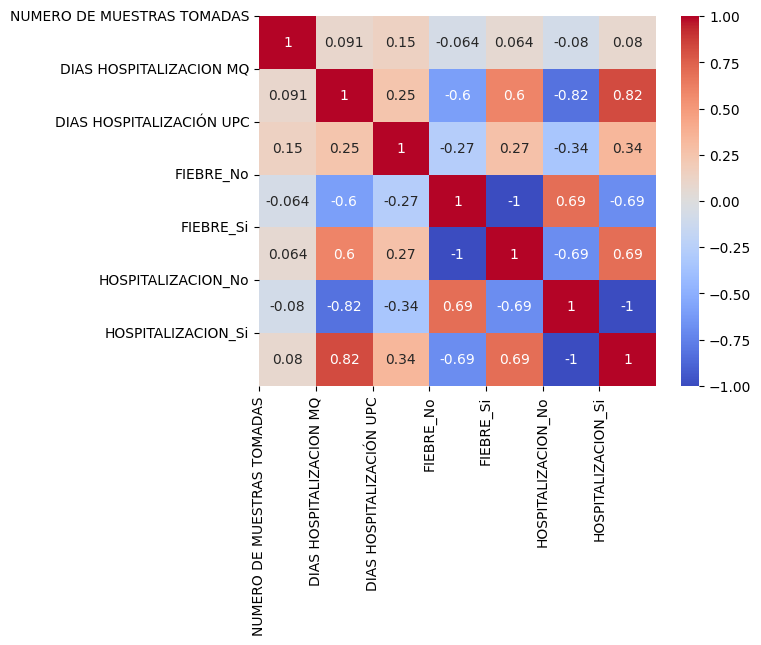

In [34]:
#Evalúo cuantos pacientes si fueron hospitalizados, omitiendo los nulos y busco una correlación entre las variables.

columnas_correlación = ['NUMERO DE MUESTRAS TOMADAS', 'FIEBRE', 'HOSPITALIZACION', 'DIAS HOSPITALIZACION MQ', 'DIAS HOSPITALIZACIÓN UPC']
   
# Filtra las columnas de interés en un nuevo DataFrame
df_correlación = df[columnas_correlación]

# Aplica la codificación one-hot a las columnas
df_encoded = pd.get_dummies(df_correlación)

# Calcula la matriz de correlación
correlation_matrix = df_encoded.corr()

# Crea el mapa de calor con la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Configura las etiquetas de los ejes
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Muestra el gráfico
plt.show()


Para evaluar bien genero una línea de tendencia para que sea más gráfico que si existe un patrón entre el número de 
hospitalizaciones y el hecho de se tomen muchas muestras en la biopsia, tal cual se nota que la hospitalizacón se genera
a partir de 12 muestras en adelante =)

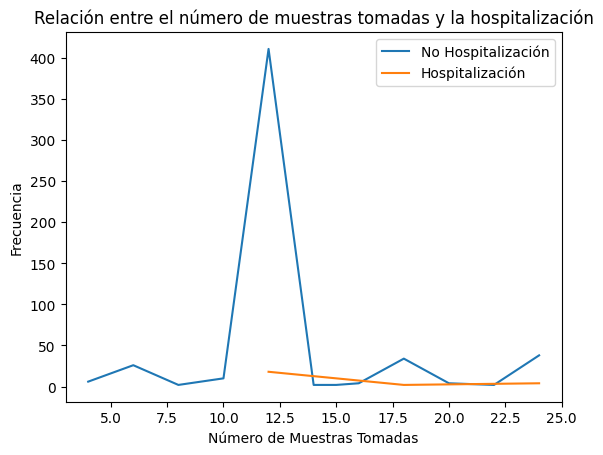

In [35]:
# Filtro los datos con hospitalización "No" y cuento el número de muestras tomadas
df_no_hospitalization = df[df['HOSPITALIZACION'] == 'No']
no_hospitalization_counts = df_no_hospitalization['NUMERO DE MUESTRAS TOMADAS'].value_counts().sort_index()

# Filtra los datos con hospitalización "Sí" y cuenta el número de muestras tomadas
df_hospitalization = df[df['HOSPITALIZACION'] == 'Si']
hospitalization_counts = df_hospitalization['NUMERO DE MUESTRAS TOMADAS'].value_counts().sort_index()

# Creo el gráfico de líneas
plt.plot(no_hospitalization_counts.index, no_hospitalization_counts.values, label='No Hospitalización')
plt.plot(hospitalization_counts.index, hospitalization_counts.values, label='Hospitalización')
plt.xlabel('Número de Muestras Tomadas')
plt.ylabel('Frecuencia')
plt.title('Relación entre el número de muestras tomadas y la hospitalización')
plt.legend()
plt.show()

En base a la matriz anterior se llega a notar que existe una correlación entre el número de muestras tomadas y las hospitalziaciones,
por lo cual considero basar en esto mi modelo machine learning de clasificación, sin embargo como problemática princial noté que al
encontrarse los valores en numeros enteros los modelos que había usado no encontraban un patrón así que lo agrupo en rangos y de allí si genero el modelo

In [36]:
#Organizo los datos para que queden en rangos, considerando que no se logra hacer una buena clasificación del modelo en casos contrarios

def agrupar_numeros_muestras(valor):
    if valor >= 4 and valor <= 10:
        return "RANGO 4-10"
    elif valor >= 12 and valor <= 18:
        return "RANGO 12-18"
    elif valor >= 19 and valor <= 24:
        return "RANGO 19-24"
    else:
        return "OTRO"
df['RANGO_NUMERO_MUESTRAS'] = df['NUMERO DE MUESTRAS TOMADAS'].apply(agrupar_numeros_muestras)
df['RANGO_NUMERO_MUESTRAS'].value_counts()


RANGO_NUMERO_MUESTRAS
RANGO 12-18    473
RANGO 19-24     48
RANGO 4-10      44
Name: count, dtype: int64

Una vez que tengo todo en rangos etarios procedo a seguir o continuar con mi modelo de machine learning de clasificación, decidí usar
random forest sin embargo probé con modelos de regresión logística que en principio presentaban el mismo problema del rango etario, al no ser
valores categóricos no me agrupaban bien. Bueno menciono que me dí cuenta visualmente del patrón en el EDA y por eso hice el mapa de calor

In [37]:
#Importo las librerías para datos de entrenamiento y evaluación del modelo de sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Elimino filas con valores faltantes
df.dropna(inplace=True)

# Dividir los datos en características (X) y variable objetivo (y)
X = df.drop('NUMERO DE MUESTRAS TOMADAS', axis=1)
y = df['NUMERO DE MUESTRAS TOMADAS']

# Codifico variables categóricas
X_encoded = pd.get_dummies(X)

# Divido los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Imputo valores faltantes, dado que el modelo no funciona en caso contrario.
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Creo el modelo RandomForestClassifier
model = RandomForestClassifier()

# Entrenar el modelo
model.fit(X_train_imputed, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_imputed)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy}")

#Mi model es preciso en un 94%  


Precisión del modelo: 0.9541284403669725


In [38]:
#Reevaluo mis datos para saber si la precisión o clasificación del modelo es buena, recall 
# que es una medida entre la proporción de muestras relevantes que fueron correctamente identificadas con un 95% y f1 que es 
#la relación entre mi recall y mi precision es de 97% por lo que confirmo que mi modelo es realmente bueno. 
from sklearn.metrics import classification_report

# Entreno el modelo
model.fit(X_train_imputed, y_train)

# Genero la predicción en el conjunto de prueba
y_pred = model.predict(X_test_imputed)

# Se calculan las métricas de evaluación
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

         4.0       1.00      1.00      1.00         1
         6.0       0.75      1.00      0.86         3
        10.0       1.00      0.67      0.80         3
        12.0       0.96      0.98      0.97        84
        16.0       1.00      1.00      1.00         1
        18.0       0.67      0.57      0.62         7
        22.0       1.00      1.00      1.00         1
        24.0       1.00      1.00      1.00         9

    accuracy                           0.94       109
   macro avg       0.92      0.90      0.91       109
weighted avg       0.94      0.94      0.94       109



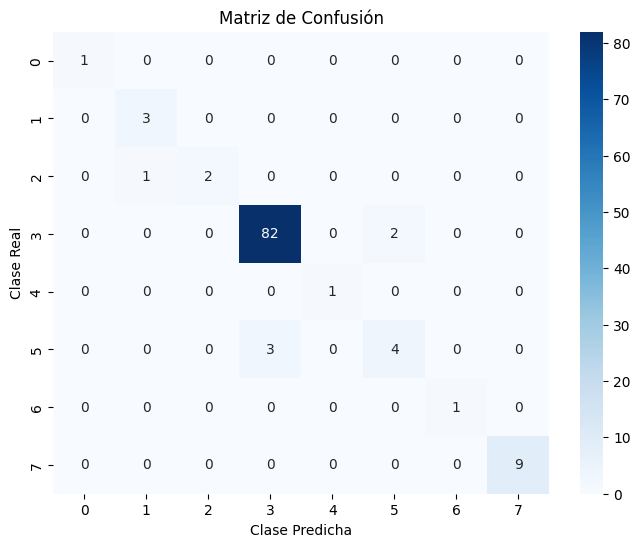

In [39]:
#Adicionalmente, he generado una matriz de confusión para evaluar la precisión de mi modelo. 
#Según los resultados obtenidos, el accuracy alcanzado es del 94%, 
#lo cual indica que el modelo ha clasificado correctamente el 94% de las muestras.
#Esta alta precisión demuestra la efectividad del modelo en predecir correctamente 
#la hospitalización de los pacientes. Los resultados de la matriz de confusión respaldan 
#y confirman la calidad de los datos y el rendimiento del modelo.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculo la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión')
plt.show()
